# NLP: Time series Forecasting with a LSTM

Long short-term memory networks, or LSTMs, were developed the 1997 and continue to be part of state-of-the-art models for sequential data. They represent a powerful method of inference on time-series and language data because of their ability to capture long-term dependencies. Some of its applications include:


* Time series prediction
* Speech recognition.
* Grammar learning.
* Robot control.
* Music composition.
* $\dots$


### 1. Import the necessary packages

In [1]:
import numpy as np 
import pandas as pd 
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline


Enter in how much steps we will enroll the network.

RNN/LSTM/GRU can be taught patterns over times series as big as the number of times you enrol them, and no bigger (fundamental limitation). 

So by design these networks are deep/long to catch recurrent patterns.



#### Auxiliary functions:

In [2]:

def load_data(datasetname, column, seq_len, normalise_window):
    """
    datasetname: name of the dataset (pandas)
    column = name of the column to extract
    seq_len = sequence 
    normalize = True/False
    """
    
    data = datasetname.loc[:,column]

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)
    
    
    # Last 10% is used for validation test
    # first 90% for training
    row_train = round(0.9 * result.shape[0])
    train = result[:int(row_train), :]
    np.random.seed(0)
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row_train):, :-1]
    y_test = result[int(row_train):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

In [3]:
def normalise_windows(window_data):
    # A support function to normalize a dataset
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of <prediction_len> steps before shifting prediction run forward by <prediction_len> steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

    


<h2>Sin Wave Forecasting </h2>

### 2. Reading the Data

In [4]:
# Load the data
dataset = pd.read_csv('data/SinWaveData.csv')
print(dataset.shape)
dataset.head()

(5001, 1)


,Wave
0,0.841471
1,0.873736
2,0.902554
3,0.927809
4,0.949402


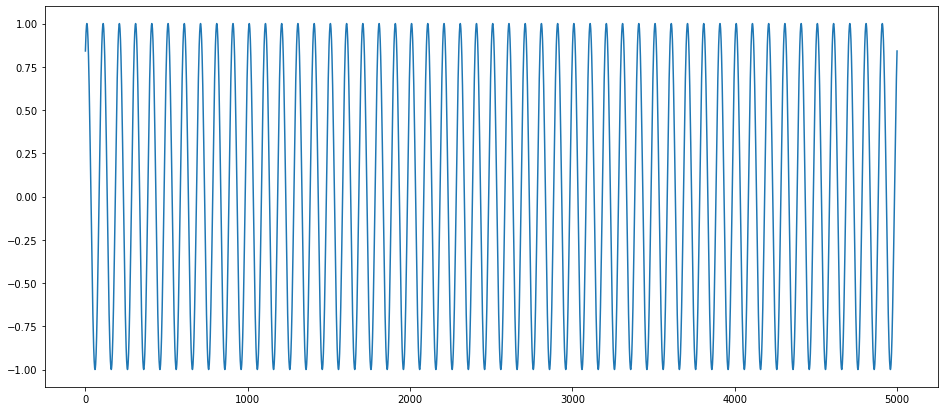

In [5]:
dataset["Wave"][:].plot(figsize=(16,7),legend=False);

In [6]:
# The label is what we are predicting (Y-axis of the wave)
# This data is already normalized
Enrol_window = 100
feature_train, label_train, feature_test, label_test = load_data(dataset, 'Wave', Enrol_window, False)

In [7]:
#Each row in the feature_train, corresponds to a sequence of 100 elements of the sinwave
#Each row in the label_train variable corresponds to the variable following a row in the feature train
print('Dimension of the input features')
print(feature_train.shape)

Dimension of the input features
(4410, 100, 1)


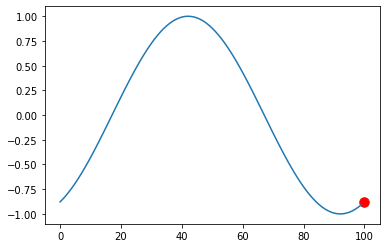

In [8]:
plt.plot(feature_train[0,:,0])
plt.scatter(len(feature_train[0,:,0]),label_train[0],s=90,color='r');

### 3. Buiulding the LSTM model

In [9]:
# Construct LSTM model 
model = Sequential()
model.add(LSTM(50,return_sequences=True, input_shape=(feature_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "linear"))

### 4. Compile the model

In [10]:
model.compile(loss='mse', optimizer='adam')

In [11]:
#Train the model
model.fit(feature_train, label_train, batch_size=512, epochs=10, validation_data = (feature_test, label_test))


Train on 4410 samples, validate on 490 samples
Epoch 1/10
4410/4410 [==============================] - 14s 3ms/sample - loss: 0.2852 - val_loss: 0.1119
Epoch 2/10
4410/4410 [==============================] - 7s 2ms/sample - loss: 0.0608 - val_loss: 0.0144
Epoch 3/10
4410/4410 [==============================] - 7s 2ms/sample - loss: 0.0136 - val_loss: 0.0063
Epoch 4/10
4410/4410 [==============================] - 7s 2ms/sample - loss: 0.0085 - val_loss: 0.0030
Epoch 5/10
4410/4410 [==============================] - 10s 2ms/sample - loss: 0.0073 - val_loss: 0.0010
Epoch 6/10
4410/4410 [==============================] - 7s 2ms/sample - loss: 0.0051 - val_loss: 6.5903e-04
Epoch 7/10
4410/4410 [==============================] - 7s 2ms/sample - loss: 0.0050 - val_loss: 2.3077e-04
Epoch 8/10
4410/4410 [==============================] - 7s 1ms/sample - loss: 0.0044 - val_loss: 2.7758e-04
Epoch 9/10
4410/4410 [==============================] - 9s 2ms/sample - loss: 0.0040 - val_loss: 1.3379e-04

### 5. Make predictions with the model

In [12]:
#Let's use the model and predict the wave
# create a predictions on 100 points, 99 points + 1pred, 98 points + 2 points, etc...
predictions= predict_sequence_full(model, feature_test, Enrol_window)

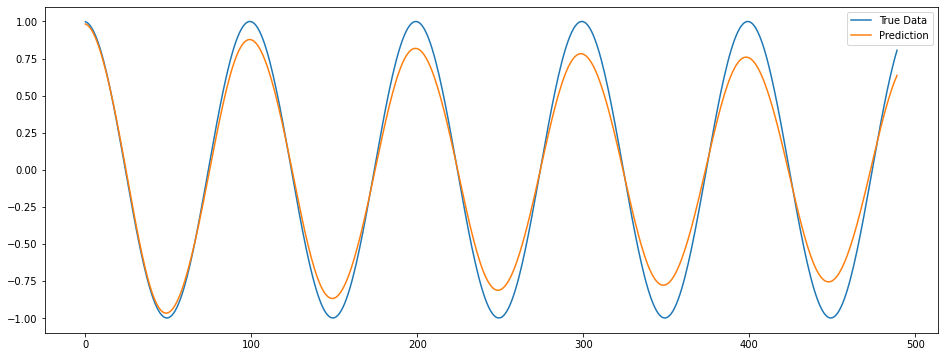

In [13]:
# plot
fig = plt.figure(figsize=(16,6)) 
plt.plot(label_test, label='True Data') 
plt.plot(predictions, label='Prediction') 
plt.legend();

<h2>Predict the stock market </h2>

### 1. Read the stock market data

In [14]:
# Let's get the stock data
dataset = pd.read_csv('data/AMZN.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


### 2. Divide the data in train and test set using an enrol window

In [15]:
# Apply the same approach as in the sin wave (on the Close column)
# This time we are going to normalize the data !
feature_train, label_train, feature_test, label_test = load_data(dataset, 'Close', Enrol_window, True)

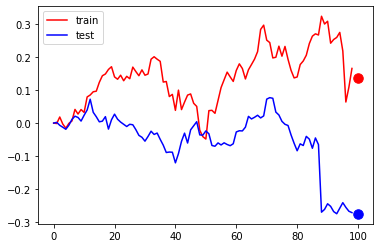

In [16]:
fig,ax = plt.subplots(1,1)
plt.plot(feature_train[0,:-1],'r')
plt.scatter(len(feature_train[0,:,0]),label_train[0],s=90,color='r');

plt.plot(feature_train[10,:-1],'b')
plt.scatter(len(feature_train[10,:,0]),label_train[10],s=90,color='b');

plt.legend(['train', 'test'])

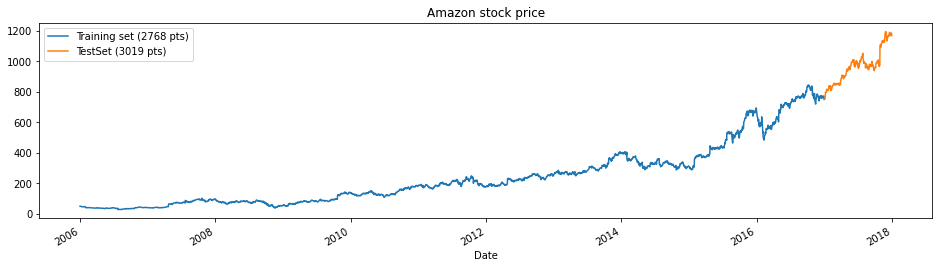

In [17]:
dataset["Close"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["Close"]['2017':].plot(figsize=(16,4),legend=True) # 10% is used for thraining data which is approx 2017 data
plt.legend(['Training set ('+str(len(dataset["Close"][:'2016'].values))+' pts)',
            'TestSet ('+str(len(dataset["Close"][:'2017'].values))+' pts)'])
plt.title('Amazon stock price')
plt.show()

### 3. Define the LSTM architecture

In [18]:
#same LSTM model as in the sinwave example
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(feature_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "linear"))
model.compile(loss='mse', optimizer='adam')

In [19]:
#Train the model
model.fit(feature_train, label_train, batch_size=512, epochs=5, validation_data = (feature_test, label_test))


Train on 2626 samples, validate on 292 samples
Epoch 1/5
2626/2626 [==============================] - 9s 3ms/sample - loss: 0.0260 - val_loss: 0.0042
Epoch 2/5
2626/2626 [==============================] - 5s 2ms/sample - loss: 0.0071 - val_loss: 0.0028
Epoch 3/5
2626/2626 [==============================] - 4s 1ms/sample - loss: 0.0065 - val_loss: 0.0012
Epoch 4/5
2626/2626 [==============================] - 4s 2ms/sample - loss: 0.0055 - val_loss: 9.8202e-04
Epoch 5/5
2626/2626 [==============================] - 4s 2ms/sample - loss: 0.0045 - val_loss: 9.1131e-04


### 4. Use the model to make predictions

In [20]:
#Let's use the model and predict the stock
predicted_stock_price = model.predict(feature_test)

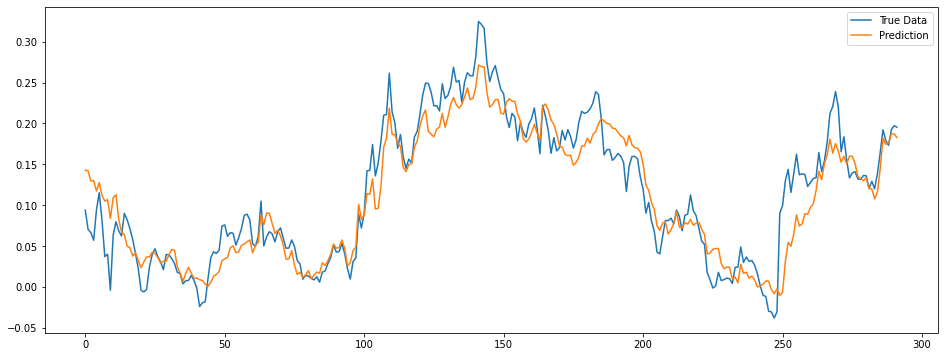

In [21]:
# plot
fig = plt.figure(figsize=(16,6)) 
plt.plot(label_test, label='True Data') 
plt.plot(predicted_stock_price, label='Prediction') 
plt.legend();

 Let's step back and actually see what we did. We created a testset of 100 (enrol_window) actual datapoints and ask to predict nr 101 (enrol window +1).Hence the fantastic result.

Like the sinewave example we need to predict a new point based on the actual last 100 points, the next point on 99 actual points and 1 prediction, the next point on 98 actuals and 2 predictions, and so forth.   
Lets make some 50 predictions ahead in the future and do this every 50 times to get a bearing how the model predicts

In [22]:
predictions = predict_sequences_multiple(model, feature_test, Enrol_window, 50)
 

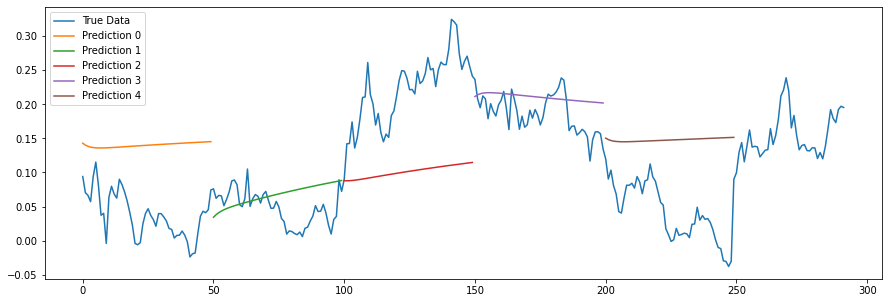

In [23]:
fig = plt.subplots(1,1,figsize=(15,5))
plt.plot(label_test, label='True Data')
for i, data in enumerate(predictions):
    padding = [None for p in range(i * 50)]
    plt.plot(padding + data, label='Prediction '+str(i))
    plt.legend()

